# On-Click Movie NLP Analysis (X-Men - Sample)

---
__Author:__ Shreyansh Padarh <br>
__Email:__ shreyansh.padarha@hotmail.com<br>
__Linkedin:__ https://www.linkedin.com/in/shreyansh-padarha/<br>

---

## Imoirting Required Libraries


In [25]:
#File handling and system operations
import os
import glob

#Numeric and data manipulation
import numpy as np
import pandas as pd

#Text and language processing
import re
from nltk import tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import pos_tag

#Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly import tools
from plotly.subplots import make_subplots
import chart_studio.plotly as py

#Natural Language Processing (NLP)  (For Topic Modelling)
from gensim import corpora, models

#Word cloud generation
from wordcloud import WordCloud

#Computer vision
import cv2

#Spacy for advanced NLP tasks
import spacy

#Additional libraries for data analysis and visualization
from collections import Counter

In [ ]:

class MovieAnalysis:

    def __init__(self,imdb_id):
        self.imdb_id = imdb_id


    def create_movie_dataset(self, imdb_id,character_scripts_locations, script = False):
            character_scripts = []

            data = []

            for movies in character_scripts_locations:
                id = movies.split('/')[-2].split('_')[1] #Eg. File Name: 

                if id[0]=='0':
                    id = id[1:]
                    
                if id == self.imdb_id:
                    movie_name = movies.split('/')[-2].split('_')[0]
                    character_scripts = glob.glob(movies + '*.txt')

            for character in character_scripts:
                character_name = character.split('/')[-1].split('_')[0]

                with open(character,'r') as file:
                    lines = file.readlines()

                for line_i in lines:
                    segment = line_i.split(')')[0]
                    segment_scene = line_i.split(')')[1]
                    label = line_i.split(')')[2].split(':')[0].strip()

                    text_ = line_i.split(')')[2].split(':')[1:]
                    text = ''
                    for words in text_:
                        text += words
                    text = text.strip()

                    character_dict = {'character' : character_name,
                                'segment' : segment,
                                'segment_scene': segment_scene,
                                'kind': label,
                                'content': text}
                
                    data.append(character_dict)

            try: 
                df = pd.DataFrame.from_dict(data)

                if script:
                    df.segment = df.segment.astype('Int32')
                    df.segment_scene = df.segment_scene.astype('Int32')
                    df = df.sort_values(by=['segment', 'segment_scene'])

                    script = df.content.values
                    entire_script = ''
                    for lines in script:
                        entire_script += lines

                    return entire_script

                return df
            
            except:
                return


## create_movie_dataset() function

The function takes three parameters:
1. __imdb_id:__ a string id
2. __character_scripts_locations:__ he location of the movie scripts files
3. __script__ an optional parameter with a default value of False. If True the returned value of the funciton will be the entrie movie's script as a corpus.

__Proces__

1. The function initializes an empty list called ```character_scripts``` and an empty list called ```data```.

2. It iterates over the provided character_scripts_locations, extracts the IMDb ID from the file paths, and checks if it matches the specified imdb_id. If there is a match, it retrieves the movie name and locates character scripts using the glob module.

3. For each character script file, it reads the content line by line. Each line is then processed to extract information such as segment, segment_scene, label, and text. This information is stored in a dictionary called character_dict, which is appended to the data list.

4. The code attempts to create a pandas DataFrame (df) (try-except-catch) from the collected data. If the optional parameter script is True, it processes the DataFrame to sort and concatenate the script lines into a single string (entire_script). The function returns either the DataFrame or the entire concatenated script, depending on the value of the script parameter.

If an exception occurs during the DataFrame creation, the function returns None.


In [4]:
def create_movie_dataset(imdb_id,character_scripts_locations, script = False):
    character_scripts = []

    data = []

    for movies in character_scripts_locations:
        id = movies.split('/')[-2].split('_')[1] #Eg. File Name: 

        if id[0]=='0':
            id = id[1:]
            
        if id == imdb_id:
            movie_name = movies.split('/')[-2].split('_')[0]
            character_scripts = glob.glob(movies + '*.txt')

    for character in character_scripts:
        character_name = character.split('/')[-1].split('_')[0]

        with open(character,'r') as file:
            lines = file.readlines()

        for line_i in lines:
            segment = line_i.split(')')[0]
            segment_scene = line_i.split(')')[1]
            label = line_i.split(')')[2].split(':')[0].strip()

            text_ = line_i.split(')')[2].split(':')[1:]
            text = ''
            for words in text_:
                text += words
            text = text.strip()

            character_dict = {'character' : character_name,
                        'segment' : segment,
                        'segment_scene': segment_scene,
                        'kind': label,
                        'content': text}
        
            data.append(character_dict)

    try: 
        df = pd.DataFrame.from_dict(data)

        if script:
            df.segment = df.segment.astype('Int32')
            df.segment_scene = df.segment_scene.astype('Int32')
            df = df.sort_values(by=['segment', 'segment_scene'])

            script = df.content.values
            entire_script = ''
            for lines in script:
                entire_script += lines

            return df, entire_script

        return df
    
    except:
        return

### Importing Sample Movie Script (X-Men)

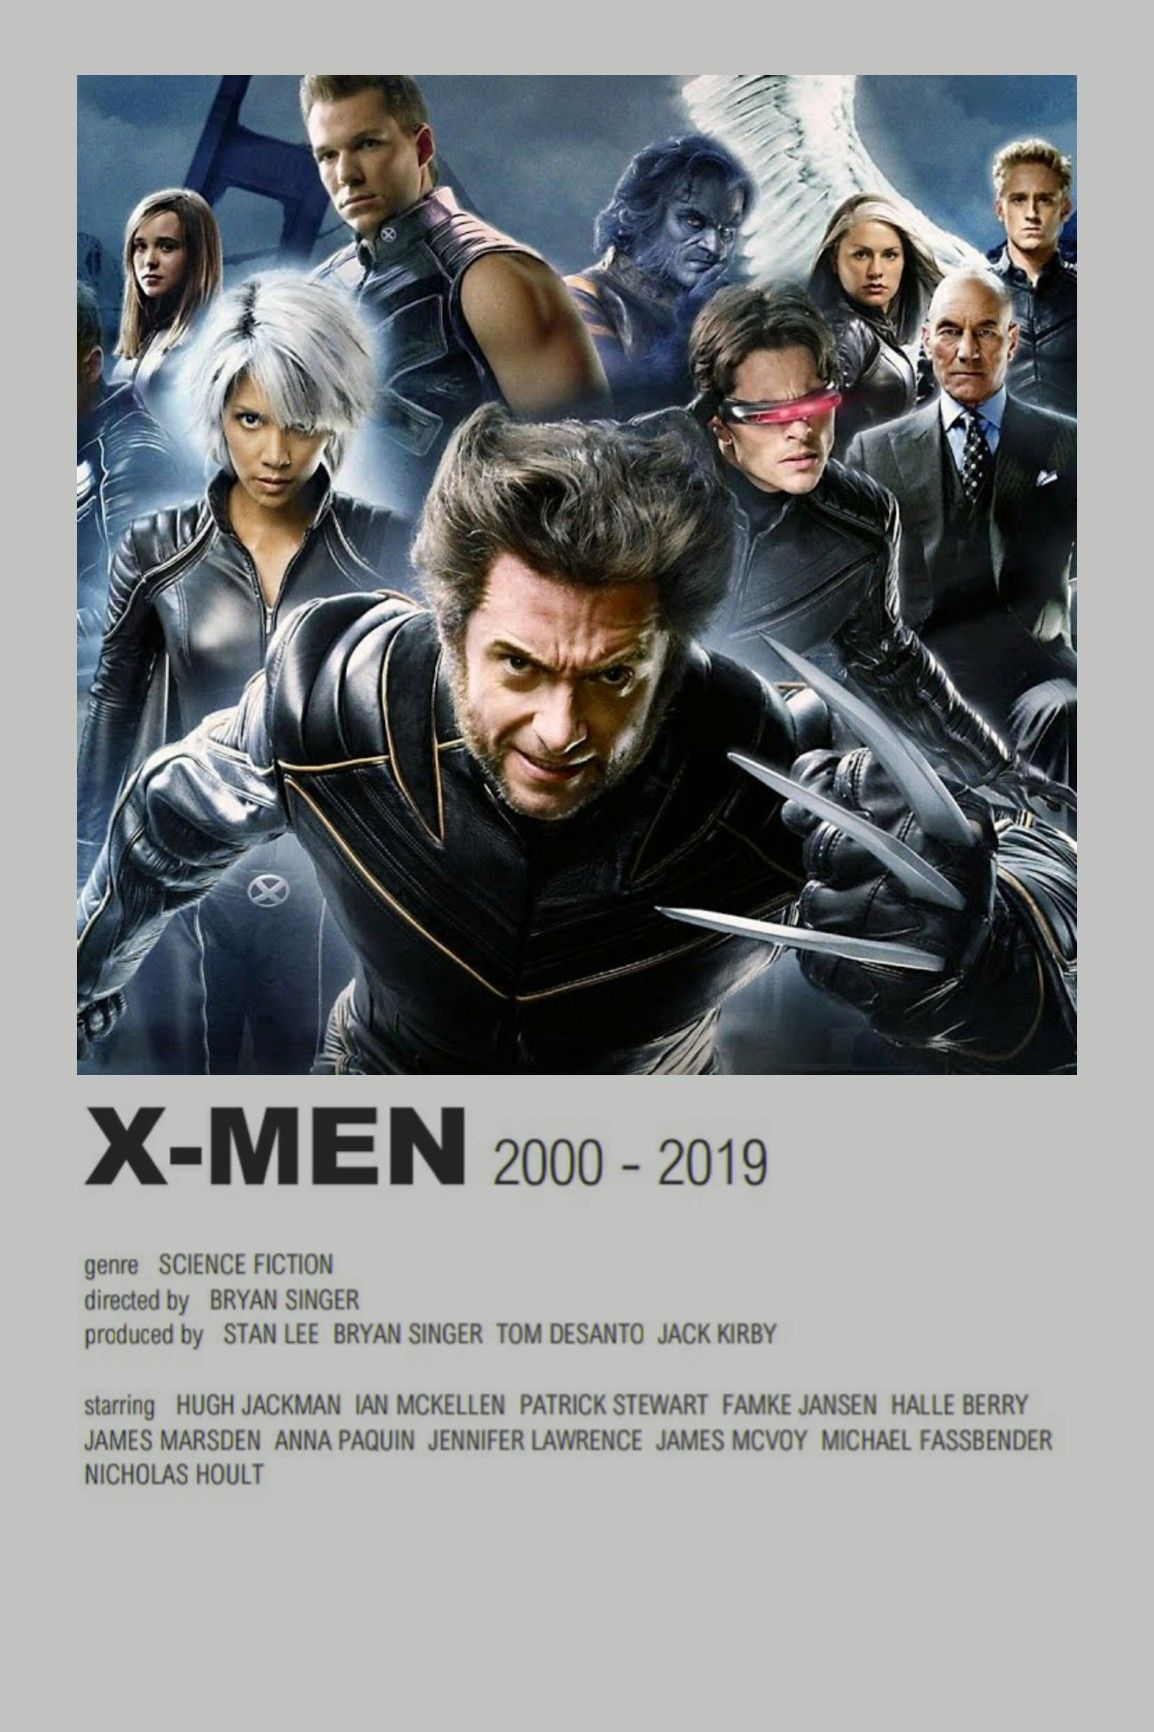

In [5]:
character_scripts_locations = glob.glob('./Data/Raw/character_scripts/*/')
imdb_id = "120903"
df = create_movie_dataset(imdb_id,character_scripts_locations,False)

In [6]:
df.sample(3)

,character,segment,segment_scene,kind,content
112,Logan Wolverine,40,4,dialog,"What is... And Before he can for another word,..."
57,Logan Wolverine,8,25,dialog,"Hey, you know what? I have a great idea. I don..."
197,Rogue,54,11,dialog,What?


---

## Number of Times Each Character Spoke / Appeared in a Movie

In [39]:
def remove_unwanted_characters(df):
    """
    Removing unwanted characters from the DataFrame.
    
    Parameters:
    + df: DataFrame containing the character data.
    
    Returns:
    + List of characters that appeared in both 'text' and 'dialog' kinds.
    """
    direct_characters = df[df['kind'] == 'text']['character'].unique()
    dialog_characters = df[df['kind'] == 'dialog']['character'].unique()
    actual_characters = [character for character in direct_characters if character in dialog_characters]
    return actual_characters

def count_character_appearances(df):
    """
    Counting the number of times each character appears in the DataFrame.
    
    Parameters:
    - df: DataFrame containing the character data.
    
    Returns:
    - Dictionary with character counts.
    """
    character_count = dict(Counter(df['character']))
    
    # Remove characters with only one appearance
    character_count = {k: v for k, v in character_count.items() if v > 1}
    
    return character_count

def plot_character_appearances(character_count, movie_name):
    """
    Plotingt the appearances of characters in the movie script.
    
    Parameters:
    - character_count: Dictionary with character counts.
    - movie_name: Name of the movie.
    """
    df_character_count = pd.DataFrame(character_count.items(), columns=['Characters', 'counts']).sort_values(by='counts')
    
    fig = px.bar(df_character_count, x='counts', y='Characters', orientation='h',
                 hover_data=df_character_count.columns, color='counts',
                 labels={'counts': '<b> Character Counts <b>'}, width=1000, height=1000)
    
    fig.update_layout(title=f'<b> Number of Times Characters appeared in the {movie_name} Movie <b>',
                      xaxis_title='<b> Counts <b>', yaxis_title='<b> Characters <b>')
    

    fig.write_html('plot_character_appearances.html') 

    iplot(fig)

def count_scenes_per_character(df, characters):
    """
    Counting the number of scenes each character appeared in.
    
    Parameters:
    - df: DataFrame containing the character data.
    - characters: List of characters.
    
    Returns:
    - Dictionary with character counts per scene.
    """
    characters_per_scene = {}
    for character in characters:
        count = df[df['character'] == character]['segment_scene'].nunique()
        characters_per_scene[character] = count
        
    return characters_per_scene

def plot_scenes_per_character(characters_per_scene, movie_name):
    """
    Plotting the number of scenes each character appeared in.
    
    Parameters:
    - characters_per_scene: Dictionary with character counts per scene.
    - movie_name: Name of the movie.
    """
    df_per_scene = pd.DataFrame(characters_per_scene.items(), columns=['Characters', 'Scene counts']).sort_values(by='Scene counts')
    
    fig = px.bar(df_per_scene, x='Scene counts', y='Characters', orientation='h',
                 hover_data=df_per_scene.columns, color='Scene counts',
                 labels={'Scene counts': '<b> Scene Counts <b>'}, width=1000, height=900,
                 color_continuous_scale=px.colors.sequential.speed)
    
    fig.update_layout(title=f'<b> Number of Scenes Each Character Spoke In, in the {movie_name} movie <b>',
                      xaxis_title='<b> Scene counts <b>', yaxis_title='<b> Characters <b>')
    


    fig.write_html('plot_scenes_per_character.html') 
    
    iplot(fig)

def main_analysis(df, movie_name):
    """
    Performing character interaction analysis for the given movie.
    
    Parameters:
    - df: DataFrame containing movie scenes and characters.
    - movie_name: Name of the movie.
    
    Returns:
    - List of characters used in the analysis.
    """
    #Extracting the  characters common in both 'text' and 'dialog' kinds
    actual_characters = remove_unwanted_characters(df)
    
    #Counting the number of times each character appears in the movie script
    character_count = count_character_appearances(df)
    
    #Plotting character appearances in the movie script
    plot_character_appearances(character_count, movie_name)
    
    #Counting the number of scenes each character appeared in
    characters_per_scene = count_scenes_per_character(df, actual_characters)
    
    #Plotting the number of scenes each character appeared in
    plot_scenes_per_character(characters_per_scene, movie_name)
    
    return actual_characters


In [40]:
characters = main_analysis(df, "X Men")

---

## Scene-Wise Sentiment Analyser

In [37]:
def film_sentiment(df_movie, moviename, colour):
    """
    Analyzes and visualizes sentiment across scenes in a movie.

    Parameters:
    - df_movie: DataFrame containing movie data.
    - moviename: Name of the movie.
    - colour: Color for the sentiment plot.

    Returns:
    - df_sentiment: DataFrame containing sentiment scores for each scene.
    """
    analyzer = SentimentIntensityAnalyzer()
    sc_sent = {}

    for x in range(len(df_movie)):
        scene = re.sub(r"[^a-zA-Z0-9.? ]+", '', df_movie.content[x])
        scene_sentence = tokenize.sent_tokenize(scene)

        # Check if the length of scene_sentence is not zero to avoid ZeroDivisionError
        if len(scene_sentence) > 0:
            sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
            for sentence in scene_sentence:
                vs = analyzer.polarity_scores(sentence)
                sentiments['compound'] += vs['compound']
                sentiments['neg'] += vs['neg']
                sentiments['neu'] += vs['neu']
                sentiments['pos'] += vs['pos']

            sentiments['compound'] = sentiments['compound'] / float(len(scene_sentence))
            sentiments['neg'] = sentiments['neg'] / float(len(scene_sentence))
            sentiments['neu'] = sentiments['neu'] / float(len(scene_sentence))
            sentiments['pos'] = sentiments['pos'] / float(len(scene_sentence))
            dic = 'scene_' + str(x)
            sc_sent[dic] = sentiments
        else:
            # Handle the case where scene_sentence is empty
            dic = 'scene_' + str(x)
            sc_sent[dic] = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}

    sents = [sc_sent[keys] for keys in sc_sent]
    df_sentiment = pd.DataFrame(sents)
    df_zero = pd.DataFrame(0, df_sentiment.index, columns=['Zero'])

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_sentiment.index, y=df_sentiment['compound'], mode='lines',
                             name='Average Sentiment', line=dict(color=colour)))
    fig.add_trace(go.Scatter(x=df_zero.index, y=df_zero['Zero'], mode='lines', name='Zero line',
                             line=dict(color='crimson', dash='dot')))
    fig.update_layout(title='<b> Sentiment across the ' + moviename + ' Movie <b>',
                      xaxis_title='<b> Scenes <b>', yaxis_title='<b> Average Sentiments <b>', showlegend=True)
    
    fig.write_html('scenewise_sentiment.html')
    fig.show()



In [38]:
film_sentiment(df, 'X-Men', 'darkcyan')

---

## Visualizing Emotional Arcs in Movie Scenes

In [16]:
def film_emotional_arc(df_movie):
    """
    Analyzes and visualizes emotional arcs across scenes in a movie.

    Parameters:
    - df_movie: DataFrame containing movie data.

    Returns:
    - df_scene_emotions: DataFrame containing emotional scores for each scene.
    """
    def cap_sentence(s):
        return re.sub("(^|\s)(\S)", lambda m: m.group(1) + m.group(2).upper(), s)

    df_contents = df_movie[['segment', 'content']]
    df_emotions = pd.read_csv('./Data/NRC Word-Emotion Association Lexicon/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
                              names=["word", "emotion", "association"], sep='\t')
    df_emotion_word = df_emotions.pivot(index='word', columns='emotion', values='association').reset_index()
    emotions = df_emotion_word.columns.drop('word').tolist()
    df_emo = pd.DataFrame(0, df_contents.index, columns=emotions)
    stemmer = SnowballStemmer("english")

    for x in range(len(df_contents)):
        scene_conts = re.sub(r"[^a-zA-Z0-9 ]+", '', df_contents.content[x])
        doc = word_tokenize(scene_conts)
        for word in doc:
            word = stemmer.stem(word.lower())
            emotion_score = df_emotion_word[df_emotion_word.word == word]
            if not emotion_score.empty:
                for emotion in emotions:
                    df_emo.at[x, emotion] += emotion_score[emotion]

    df_scene_emotions = pd.concat([df_contents, df_emo], axis=1)
    df_scene_emotions['word_count'] = df_scene_emotions['content'].apply(tokenize.word_tokenize).apply(len)
    for emotion in emotions:
        df_scene_emotions[emotion] = df_scene_emotions[emotion] / df_scene_emotions['word_count']

    fig = make_subplots(rows=5, cols=2, subplot_titles=(
        cap_sentence(emotions[0]), cap_sentence(emotions[1]), cap_sentence(emotions[2]),
        cap_sentence(emotions[3]), cap_sentence(emotions[4]), cap_sentence(emotions[5]),
        cap_sentence(emotions[6]), cap_sentence(emotions[7]),
        cap_sentence(emotions[8]), cap_sentence(emotions[9])))

    row = 0
    count = 0
    for x in emotions:
        if count % 2:
            fig.add_trace(go.Scatter(x=df_scene_emotions.index, y=df_scene_emotions[x]), row=row, col=2)
        else:
            row += 1
            fig.add_trace(go.Scatter(x=df_scene_emotions.index, y=df_scene_emotions[x]), row=row, col=1)
        count += 1
        fig.update_xaxes(title_text='Scenes', dtick=20)
        fig.update_yaxes(title_text="Average Sentiment")

    fig.update_layout(height=1500, width=1000,
                      title_text="<b> Emotional arcs identified across the scenes <b>", showlegend=False)
    fig.show()


In [15]:
film_emotional_arc(df)

---

## Visualizing Emotional Arcs in Movie Scenes (Character-Specific)

In [38]:
def emotional_arc_xter_plot(df_movie, character):
    """
    Analyzes and visualizes emotional arcs of a character across scenes in a movie.

    Parameters:
    - df_movie: DataFrame containing movie data.
    - character: Name of the character.

    Returns:
    - df_xter_emotions: DataFrame containing emotional scores for the character in each scene.
    """
    def cap_sentence(s):
        return re.sub("(^|\s)(\S)", lambda m: m.group(1) + m.group(2).upper(), s)

    def xter_count_perscene(df, characters):
        sc_xters = []
        sc_dia = []

        for x in range(len(df)):
            sc_xtrs = []
            sc_di = []

            if df['character'][x] == character:
                segment_scene = df['segment_scene'][x]
                content = df['content'][x]

                sc_xtrs.append(character)
                sc_di.append(content)

                sc_xters.append(sc_xtrs)
                sc_dia.append(sc_di)
            else:
                sc_xters.append(0)  # Set 0 for scenes where the character is not present
                sc_dia.append(0)    # Set 0 for scenes where the character is not present

        # Count the appearance of the character in each scene
        sc_cts = [1 if x == character else 0 for x in df['character']]
        df_counts = pd.DataFrame(sc_cts, columns=[character])

        df_scene_dialogue = pd.DataFrame(list(zip(sc_xters, sc_dia)), columns=['characters', 'dialogues'])
        return df_counts, df_scene_dialogue


    df_cts, df_xt = xter_count_perscene(df_movie, character)

    df_emotions = pd.read_csv('./emotions/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
                              names=["word", "emotion", "association"], sep='\t')

    df_emotion_word = df_emotions.pivot(index='word', columns='emotion', values='association').reset_index()
    emotions = df_emotion_word.columns.drop('word').tolist()
    df_emo = pd.DataFrame(0, df_xt.index, columns=emotions)
    stemmer = SnowballStemmer("english")
    df_xt['dialogues'] = df_xt.apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', '', str(x['dialogues'])).lower(), axis=1)

    for x in range(len(df_xt)):
        scene_contents = df_xt['dialogues'][x]
        doc = word_tokenize(scene_contents)
        for word in doc:
            word = stemmer.stem(word.lower())
            emotion_score = df_emotion_word[df_emotion_word.word == word]
            if not emotion_score.empty:
                for emotion in emotions:
                    df_emo.at[x, emotion] += emotion_score[emotion]

    df_xter_emotions = pd.concat([df_xt, df_emo], axis=1)
    df_xter_emotions['word_count'] = df_xter_emotions['dialogues'].apply(tokenize.word_tokenize).apply(len)

    df_xter_emotions = df_xter_emotions.fillna(0)

    for emotion in emotions:
        df_xter_emotions[emotion] = df_xter_emotions[emotion] / df_cts[character]

        df_xter_emotions = df_xter_emotions.fillna(0)

    fig = make_subplots(rows=5, cols=2, subplot_titles=(
        cap_sentence(emotions[0]), cap_sentence(emotions[1]), cap_sentence(emotions[2]),
        cap_sentence(emotions[3]), cap_sentence(emotions[4]), cap_sentence(emotions[5]),
        cap_sentence(emotions[6]), cap_sentence(emotions[7]),
        cap_sentence(emotions[8]), cap_sentence(emotions[9])))

    row = 0
    count = 0
    for x in emotions:
        if count % 2:
            fig.add_trace(go.Scatter(x=df_xter_emotions.index, y=df_xter_emotions[x]), row=row, col=2)
        else:
            row += 1
            fig.add_trace(go.Scatter(x=df_xter_emotions.index, y=df_xter_emotions[x]), row=row, col=1)
        count += 1
        fig.update_xaxes(title_text='Scenes', dtick=20)
        fig.update_yaxes(title_text="Average Sentiment")

    fig.update_layout(height=1500, width=1000,
                      title_text="<b> Emotional arcs of " + character + " across the scenes <b>", showlegend=False)
    fig.show()



In [39]:
df_ = emotional_arc_xter_plot(df,'Logan Wolverine')

---

# POS (Parts of Speec Tagging)

In [33]:
 # User Defined Function to perform POS tagging 
def pos_tagging(df):
    #Concatenating the content column to create a corpus
    corpus = " ".join(df['content'])

    # Tokenizing the corpus
    words = word_tokenize(corpus)
    tagged = pos_tag(words) 
    return tagged 

# Defining the POS tag mappings 
pos_tag_mappings = {
              'CC': 'Coordinating conjunction',
              'CD': 'Cardinal number',
              'DT': 'Determiner',
              'EX': 'Existential there',
              'FW': 'Foreign word',
              'IN': 'Preposition or subordinating conjunction',
              'JJ': 'Adjective',
              'JJR': 'Adjective, comparative',
              'JJS': 'Adjective, superlative',
              'LS': 'List item marker',
              'MD': 'Modal',
              'NN': 'Noun, singular or mass',
              'NNS': 'Noun, plural',
              'NNP': 'Proper noun, singular',
              'NNPS': 'Proper noun, plural',
              'PDT': 'Pre determiner',
              'POS': 'Possessive ending',
              'PRP': 'Personal pronoun',
              'PRP$': 'Possessive pronoun',
              'RB': 'Adverb',
              'RBR': 'Adverb, comparative',
              'RBS': 'Adverb, superlative',
              'RP': 'Particle',
              'S': 'Simple declarative clause',
              'SBAR': 'Clause introduced by a subordinating conjunction',
              'SBARQ': 'Direct question introduced by a wh-word or wh-phrase',
              'SINV': 'Inverted declarative sentence',
              'SQ': 'Inverted yes/no question',
              'SYM': 'Symbol',
              'VBD': 'Verb, past tense',
              'VBG': 'Verb, gerund or present participle',
              'VBN': 'Verb, past participle',
              'VBP': 'Verb, non-3rd person singular present',
              'VBZ': 'Verb, 3rd person singular present',
              'WDT': 'Wh-determiner',
              'WP': 'Wh-pronoun',
              'WP$': 'Possessive wh-pronoun',
              'WRB': 'Wh-adverb'
}

# User Defined Function to create a customized bar chart of POS tags 
def create_pos_tag_bar_chart(tags):
    tag_freq = FreqDist(tag for (word, tag) in tags)
    top_tags = tag_freq.most_common(25)  # Getting the top 25 tags
    top_tags = [(pos_tag_mappings.get(tag, tag), count) for tag, count in top_tags]  # Substituting the mappings

    # Creating a bar chart using Plotly
    fig = px.bar(
        top_tags,
        x=1,  # Counts
        y=0,  # POS Tags
        orientation='h',  # Horizontal bar chart
        color=0,  # Color based on POS Tags
        labels={'0': 'POS Tags', '1': 'Frequency'},
        title='Top 25 POS Tags',
    )

    fig.write_html("pos.html")

    # Show the plot
    fig.show()
    

In [34]:
pos_tags = pos_tagging(df)
create_pos_tag_bar_chart(pos_tags)

---

## Name Entity Recognition

In [23]:
def perform_ner_and_plot(data):
    #Concatenating the content column to form a corpus
    corpus = " ".join(data["content"])

    # Performing Named Entity Recognition (NER) using spaCy
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(corpus)

    #Extracting the entities and their labels
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    #Createing a DataFrame from the entities
    entities_df = pd.DataFrame(entities, columns=["Entity", "Label"])

    #Bar chart of entity labels
    label_counts = entities_df["Label"].value_counts()
    fig1 = px.bar(label_counts, x=label_counts.index, y=label_counts.values,
                  labels={'x': 'Entity Label', 'y': 'Count'},
                  title='Named Entity Recognition: Entity Label Distribution',
                  color=label_counts.index)

    #Word cloud of entities
    wordcloud_data = entities_df.groupby("Entity").size().reset_index(name='Count')
    fig2 = px.scatter(wordcloud_data, x='Entity', y='Count',
                      title='Named Entity Recognition: Entity Word Cloud',
                      labels={'Entity': 'Entity', 'Count': 'Count'},
                      size='Count', color='Count')

#Showing both the plots !
    fig1.show()
    fig2.show()

In [24]:
perform_ner_and_plot(df)

---

## Topic Modelling & Word Clouds

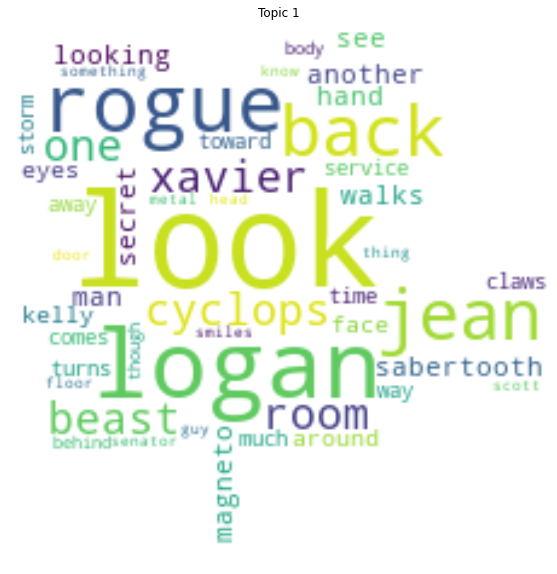

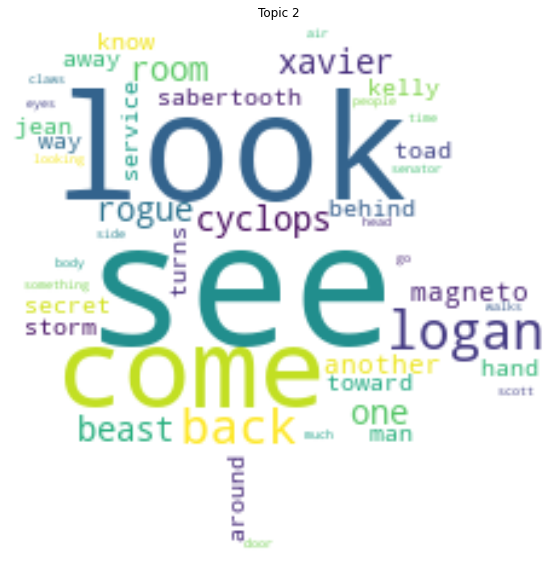

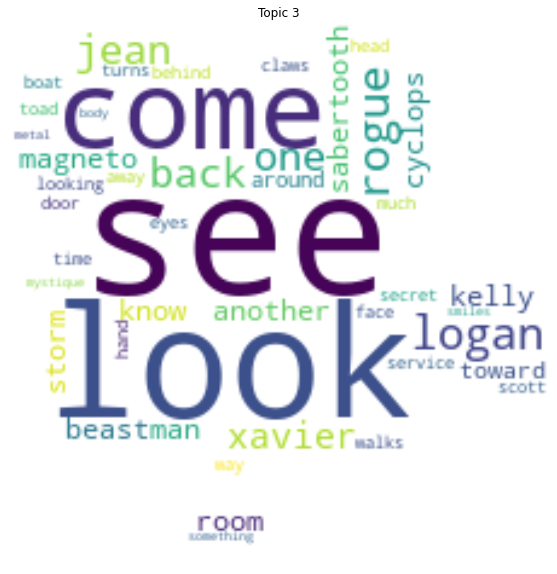

In [19]:
def perform_topic_modeling(df, mask_path, num_topics=3, num_words_per_topic=50):
    """
    Perform topic modeling on the 'content' column of a DataFrame.

    Parameters:
    - df: DataFrame with a 'content' column containing text data.
    - num_topics: Number of topics for LDA modeling.
    - num_words_per_topic: Number of words to display in each word cloud.

    Returns:
    - None (displays word clouds for each topic).
    """
    # Concatenate the content column to create a corpus
    corpus = " ".join(df['content'])

    # Tokenize the corpus
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(corpus)
    filtered_words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]

    # Create a dictionary and a document-term matrix
    dictionary = corpora.Dictionary([filtered_words])
    corpus = [dictionary.doc2bow(filtered_words)]

    # Perform topic modeling using LDA
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    custom_mask = np.array(cv2.imread('./Data/wordcloud_mask.png'))

    # Generate word clouds for each topic with the custom mask
    for topic_id in range(num_topics):
        topic_words = [word for word, _ in lda_model.show_topic(topic_id, topn=num_words_per_topic)]
        topic_text = " ".join(topic_words)

        wordcloud = WordCloud(width=800, height=800,
                             background_color='white',
                             mask=custom_mask).generate(topic_text)

        plt.figure(figsize=(10, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_id + 1}')
        plt.axis('off')
        plt.show()


# Example usage with a custom mask
custom_mask_path = './Data/wordcloud_mask.png'
perform_topic_modeling(df, custom_mask_path, num_topics=3, num_words_per_topic=50)


---